## Import and directories

In [9]:
#directories
import os
try:
    parentdir
except NameError:
    parentdir=os.getcwd()
else:
    parentdir = parentdir
# homedir=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d14Feb17_60.5_635_A2_CuAzu655';#data directory
print('The working directory is parentdir: %s' %parentdir)
# print('The data directory is homedir: %s' %homedir)
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

The working directory is parentdir: /home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/Azurin_SM_repo/Manuscript/Figure


In [26]:
#Run this once to run the .py(Analysis_bis.py) file.
os.chdir(r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/Azurin_SM_repo/Analysis')
!python Analysis_bis.py
%run Analysis_bis.py

## Time trace: Figure_2

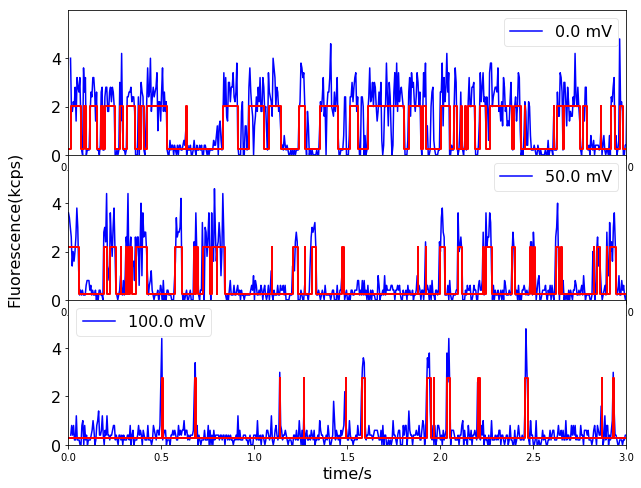

In [30]:
folder=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/30sec_trace'
fig = time_trace_plot(foldername= folder, input_potential=[0, 50, 100], pointnumbers=[1], x_lim_min=0, y_lim_min=0, x_lim_max=3, y_lim_max=6, bin=5, show_changepoint=True)
os.chdir(parentdir)
savefig('FigPart_2_timetrace.pdf', dpi=300, transparent=True)

## Toff/Ton plot_Nernst fit: Figure_3a

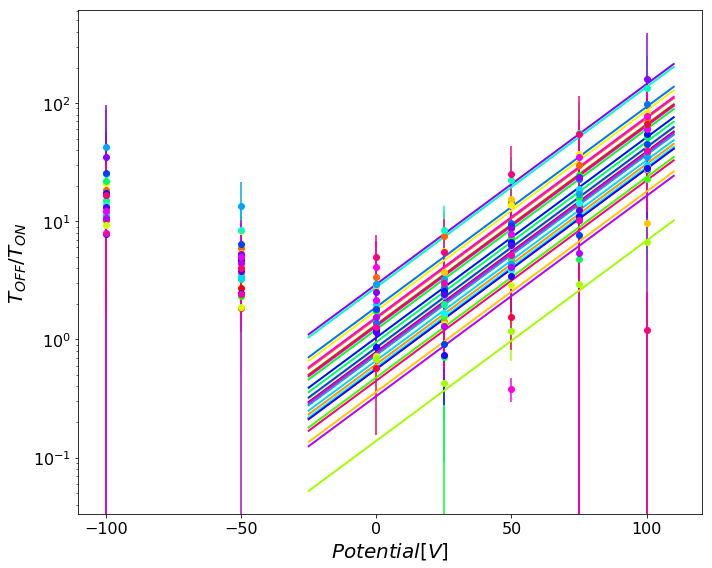

In [31]:
folder=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/30sec_trace'
figure(figsize=(10, 8))
E0_list_folder = Mid_potentials(folderpath=folder, pointnumbers=range(50), plotting=True, min_pot=-100)
os.chdir(parentdir)
savefig('FigPart_3a_Nernstplot.pdf', dpi=300, transparent=True)

## Histogram_E0: Figure_3b

In [32]:
#list of folders and their directories CuAZUATTO655
S81d7Sept16_A3_ON_60sec_trace = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160907_CuAzu655_Ferri_Asc_analysis/S81d7Sept16_0.11uW_0.2mMFerri_0.1mM Asc_A3_ON/60sec_trace';
S81d7Sept16_A5_ON = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160907_CuAzu655_Ferri_Asc_analysis/S81d7Sept16_0.11uW_0.2mMFerri_0.1mM Asc_A5_ON';
S83d10Sept16_A3_30sec_trace = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/30sec_trace'
S101d14Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d14Feb17_60.5_635_A2_CuAzu655';
S101d15Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d15Feb17_60.5_635_A2_CuAzu655';
S101d15Feb17_62o2_635_A2_CuAzu655_2nd= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d15Feb17_62.2_635_A2_CuAzu655_2nd';
S101d16Feb17_60o5_635_A3_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d16Feb17_60.5_635_A3_CuAzu655';
S104d20Feb17_60o5_635_A1_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d20Feb17_60.5_635_A1_CuAzu655';
S104d21Feb17_60o5_635_A1_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d21Feb17_60.5_635_A1_CuAzu655';
S104d21Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d21Feb17_60.5_635_A2_CuAzu655';
#Combine all folders
allfolders = [S81d7Sept16_A3_ON_60sec_trace, S81d7Sept16_A5_ON,S83d10Sept16_A3_30sec_trace , S101d14Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_62o2_635_A2_CuAzu655_2nd, S101d16Feb17_60o5_635_A3_CuAzu655,
             S104d20Feb17_60o5_635_A1_CuAzu655, S104d21Feb17_60o5_635_A1_CuAzu655, S104d21Feb17_60o5_635_A2_CuAzu655]
#Calculate midpoint potential of all points in all folders
E0_array = pd.DataFrame(index=None, columns=['Point number', 'E0_fit', 'E0_err'])
for folder in allfolders:
    E0_list = Mid_potentials(folderpath=folder, pointnumbers=range(50), plotting=False, min_pot=25)
    E0_array = E0_array.append(E0_list, ignore_index=True)

em.plot file: Point_0.11uW_A5_150mV(64)_7.pt3.datn.em.plot doesnt contain proper data
em.plot file of Point_2 with potential 100.0 doesnt exist
em.plot file of Point_14 with potential 45.0 doesnt exist
em.plot file of Point_15 with potential 100.0 doesnt exist


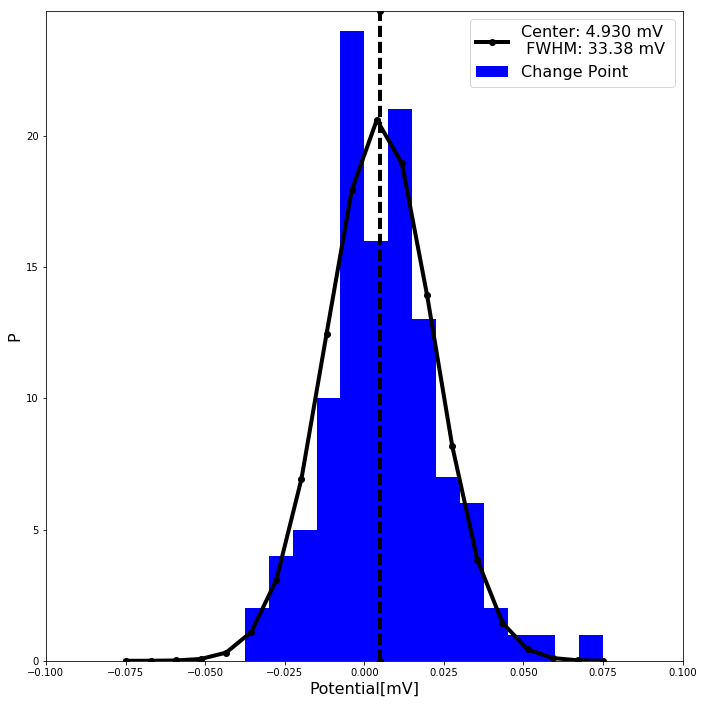

In [33]:
#MIDPOTENTIAL HISTGRAM FITTING/ PLOTTING
fig, axes = subplots(figsize=(10, 10))
# plt.figure()
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.size"] = "14"
min_range = -0.075
max_range = 0.075
range_fit = [min_range, max_range]
bins = 20
bin_centers_on = linspace(range_fit[0], range_fit[1], bins)
x=linspace(range_fit[0], range_fit[1], 100)# for a smooth fitting plot include more points

from scipy.interpolate import interp1d
from lmfit.models import GaussianModel
mod = GaussianModel()
# params = gmodel.make_params(center=0.01, amplitude=10, sigma=0.02)
#Change point--------------------------
n,bins_on1,patches = axes.hist(E0_array['E0_fit'], bins = bins, range=range_fit, color='b', label='Change Point')#E0_list from running all folder
y=n; x=bin_centers_on;
result1 = mod.fit(y, center=0.01, amplitude=10, sigma=0.02, x=x)
temp =result1.best_values
FWHM = 2*temp['sigma']*1000 #V
cent = temp['center']*1000#eV
amp = temp['amplitude']

axes.plot(x, result1.best_fit, '-ko', lw=4, label='Center: %.3f mV \n FWHM: %.2f mV' %(cent, FWHM))
amp = temp['amplitude']
height = 0.3989423*amp/max(1.e-15, temp['sigma'])
axes.plot([cent*0.001, cent*0.001], [0, height+0.2*height], '--ok', lw=4)

axes.set_xlim(-0.1, 0.1)
axes.set_ylim(0,height+0.2*height)
axes.set_ylabel('P', fontsize=16)
axes.set_xlabel('Potential[mV]', fontsize=16)
axes.legend(fontsize=16)

fig.tight_layout()
# os.chdir(homedir)
# fig.savefig('/home/biswajit/Pictures/canters_temp/MidpointPotential_distribution.pdf', dpi=300, transparent=True)
# figure()
# result.plot()
os.chdir(parentdir)
savefig('FigPart_3b_E0_hist.pdf', dpi=300, transparent=True)